In [1]:
import numpy as np
from scipy.integrate import odeint
import import_ipynb
import Vant_hoff_extrapolation as vanhof
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit, minimize
from sklearn.metrics import r2_score
from collections import OrderedDict, defaultdict
import matplotlib
from uncertainties import ufloat, unumpy
from tqdm.auto import tqdm, trange
from uncertainties.umath import *
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
sns.set_context('poster', font_scale=1.0)
# matplotlib.rcParams['legend.title_fontsize'] = 'xx-small'
%matplotlib inline

importing Jupyter notebook from Vant_hoff_extrapolation.ipynb
Stored 'on_a_fl_m' (Variable)
Stored 'on_b_fl_m' (Variable)
Stored 'off_a_fl_m' (Variable)
Stored 'off_b_fl_m' (Variable)
Stored 'tharm_m' (float64)
Stored 'on_a_fl_ss' (Variable)
Stored 'on_b_fl_ss' (Variable)
Stored 'off_a_fl_ss' (Variable)
Stored 'off_b_fl_ss' (Variable)
Stored 'tharm_ss' (float64)
Stored 'on_a_fl_ds' (Variable)
Stored 'on_b_fl_ds' (Variable)
Stored 'off_a_fl_ds' (Variable)
Stored 'off_b_fl_ds' (Variable)
Stored 'tharm_ds' (float64)


In [2]:
# model for unmodified RNA duplex
def A_annealing_model(initial_c, t, *args):
    '''
    differential equations for one-step hybridization
    initial_c is the dictionary of substrate concentrations
    t is time
    k is the list of exchange rate constants
    '''
    
    # concentrations for each molecule
    ss1, ss2, ds = initial_c
    
    # rate constant for reactions
    k1, k2 = args
    
    # differential equations
    dss1dt = -k1*ss1*ss2 + k2*ds
    
    dss2dt = -k1*ss1*ss2 + k2*ds
    
    ddsdt = k1*ss1*ss2 - k2*ds
    
    # return the results
    return [dss1dt, dss2dt, ddsdt]

# CS pathway, methyl rotates to anti in ssRNA and then anneal
def m6A_annealing_model_1(initial_c, t, *args):
    '''
    differential equations for CS pathway
    initial_c is the dictionary of substrate concentrations
    t is time
    k is the list of exchange rate constants
    '''
    
    # concentrations for each molecule
    ss_syn, ss_anti, ss2, ds_m6A= initial_c
    
    # rate constant for reactions
    k1, k2, k3, k4 = args
    
    # differential equations
    dss_syndt = -k1*ss_syn + k2*ss_anti
    
    dss_antidt = k1*ss_syn - k2*ss_anti - k3*ss_anti*ss2 + k4*ds_m6A
    
    dss2dt = -k3*ss_anti*ss2 + k4*ds_m6A
    
    dds_m6Adt = k3*ss_anti*ss2 - k4*ds_m6A
    
    # return the results
    return [dss_syndt, dss_antidt, dss2dt, dds_m6Adt]

# IF pathway, methyl rotates to anti in dsRNA after annealing
def m6A_annealing_model_2(initial_c, t, *args):
    '''
    differential equations for IF pathway
    initial_c is the dictionary of substrate concentrations
    t is time
    k is the list of exchange rate constants
    '''   
    # concentrations for each molecule
    ss_syn, ss2, ds_syn, ds_anti= initial_c
    
    # rate constant for reactions
    k3, k4, k5, k6 = args # k3: ss syn to ds syn, k5: ds syn to ds anti
    
    dss_syndt = - k3*ss_syn*ss2 + k4*ds_syn
    
    dss2dt = -k3*ss_syn*ss2 + k4*ds_syn
    
    dds_syndt = k3*ss_syn*ss2 - k4*ds_syn - k5*ds_syn + k6*ds_anti
    
    dds_antidt = k5*ds_syn - k6*ds_anti
        
    # return the results
    return [ dss_syndt, dss2dt, dds_syndt, dds_antidt]

# CS + IF
def m6A_annealing_model_3(initial_c, t, *args):
    '''
    differential equations for CS+IF pathway
    initial_c is the dictionary of substrate concentrations
    t is time
    k is the list of exchange rate constants
    '''      
    # concentrations for each molecule
    ss_syn, ss_anti, ds_syn, ss2, ds_anti = initial_c
    
    # rate constant for reactions
    k1, k2, k3, k4, k5, k6, k7, k8 = args
    
    # differential equations
    dss_syndt = -k1*ss_syn + k2*ss_anti - k7*ss_syn*ss2 + k8*ds_syn
    
    dss_antidt = k1*ss_syn - k2*ss_anti - k3*ss_anti*ss2 + k4*ds_anti
    
    dds_syndt = k7*ss_syn*ss2 - k8*ds_syn + k5*ds_anti - k6*ds_syn
    
    dds_antidt = k3*ss_anti*ss2 - k4*ds_anti - k5*ds_anti + k6*ds_syn
    
    dss2dt = - k3*ss_anti*ss2 + k4*ds_anti - k7*ss_syn*ss2 + k8*ds_syn
 
    # return the results
    return [dss_syndt, dss_antidt, dds_syndt, dss2dt, dds_antidt]
    

def complex_model_A(x, eq, k, A=1.3/1000):
    '''
    fitting equation for control unmodidied A
    x is time
    eq is 1/Keq ([AB]/[A][B]) of the reaction
    A is the starting concentration of ssRNA
    detailed derivation of this equation is in paper: https://pubs.acs.org/doi/pdf/10.1021/j100099a022
    '''
    b = -(2*A + eq)
    c = A**2
    r = np.sqrt(b**2-4*c)
    g = (b-r)/(b+r)
    p = k*r
    return (r-b)*(np.exp(p*x)-1)/(2*(g*np.exp(p*x)-1))

def complex_model_m6A(x, eq, k, A=0.9/1000):
    '''
    fitting equation for control m6A
    x is time
    eq is 1/Keq ([AB]/[A][B]) of the reaction
    A is the starting concentration of ssRNA m6A
    detailed derivation of this equation is in paper: https://pubs.acs.org/doi/pdf/10.1021/j100099a022
    '''
    b = -(2*A + eq)
    c = A**2
    r = np.sqrt(b**2-4*c)
    g = (b-r)/(b+r)
    p = k*r
    return (r-b)*(np.exp(p*x)-1)/(2*(g*np.exp(p*x)-1))


def get_fit_result(equation, model, con, t, k, ct,  p0 = [26.8/2.2e6, 2.2e6], bounds = (0, (np.inf, np.inf))):
    '''
    simulate product concentration vs time plot, and fit to equation get kon, koff, pB
    equation: equation for fitting
    model: function, kinetic model given by differential equations
    con: list, concentration of each species in the reaction
    t: time
    k: rates of each step in the kinetic model
    ct: total concentration of duplex when duplex is 100% formed
    p0: initial guess for fitting, 1/Keq and kon
    '''
    # numerical integration
    conc_results = odeint(model, con, t, k) 
    data = conc_results[:,-1]
    
    # fitting
    params, pcov = curve_fit(equation, t, data,p0 = p0, bounds = bounds)
    perr = np.sqrt(np.diag(pcov))
    
    # calculate kon, koff and pB
    c_ds = data[-1]
    pB_ss = (ct-c_ds)/ct
    kon = params[1]
    kon_err = perr[1]
    koff = ufloat(kon, kon_err)*ufloat(params[0],perr[0])
    koff_err = koff.s
    kon = ufloat(params[1], perr[1])
    
    
    return pB_ss, kon, koff, params, data, conc_results, (kon_err, koff_err)

def plot_fitting(t, data, equation, params, pB, kon, koff):
    '''
    plot the numerical interagtion together with fitting curved
    t: time
    data: list, numerical integration results of dsRNA concentration
    equation: equation used for fitting
    params: fitting results from ODE
    pB, kon and koff: fitting results
    '''
    #plot for control m6A pathway3
    fig, ax = plt.subplots(1, figsize=(8,5))

    ax.scatter(t, data, s = 35, label = 'simulated data')
    ax.set_ylabel('dsRNA concentration(M)')
    ax.set_xlabel('time(s)')
    ax.set_xlim(np.min(t)-np.max(t)/50, np.max(t)*1.1)
    ax.set_ylim(np.min(data)/1.1, np.max(data)*1.1)
    ax.plot(t, equation(t, *params), 'r', label = 'fit')
    print('kon is {:.2f}'.format(kon))
    print('koff is {:.6f}'.format(koff))

def min_fun(rate, d, t, conc):
    '''
    using simulation + minimize chi squared to get the best result
    A_annealing_model is used for numerical integration
    rate: list, kon and koff in a ss1+ss2<->ds model
    t: time
    conc: concentration of starting species, ss1, ss2 and ds
    '''
    k1, k2 = rate
    conc_results = odeint(A_annealing_model, conc, t, (k1, k2))[:,-1]
    return np.sum((conc_results[1:]-d[1:])**2/d[1:])

    
def plot_numeric_fitting(d, t, c, fit_result, printout=True):
    '''
    use numerical fitting and plot fitting results. A_annealing_model is used for numerical integration
    d: list, numerical integration results of dsRNA concentration
    t: time
    c: concentration of starting species, ss1, ss2 and ds
    fit_result: rates determined by using the fun_min function
    '''
    fig, ax = plt.subplots(1, figsize=(8,5))

    ax.scatter(t, d, s = 35, label = 'simulated data', c = 'k')
    ax.set_ylabel('dsRNA concentration(M)')
    ax.set_xlabel('time(s)')
    ax.set_xlim(np.min(t)-np.max(t)/50, np.max(t)*1.1)
    ax.set_ylim(np.min(d)/1.1, np.max(d)*1.1)

    conc_results_fit = odeint(A_annealing_model, c, t, tuple(fit_result))[:,-1]
    plt.plot(t, conc_results_fit, c = 'r')
    
    c_ds = conc_results_fit[-1]
    pB_ss = (c[0]-c_ds)/c[0]
    
    if printout:
        print('###numerical fitting')
        print('kon is {:.2f}'.format(fit_result[0]))
        print('koff is {:.6f}'.format(fit_result[1]))
    
def calc_all_pop(data, ct, printout = True):
    '''
    calculate final concentration of each species given the numerical integration data
    data: matrix, numerical integration results using a model
    ct: total concentration of duplex when duplex is the only species in the reaction
    '''
    pB = data[-1, :]
    final_pB = pB/ct
    if printout:
        for i in range(len(final_pB)):
            print('species {} population is: {:.3%}'.format(str(i+1), final_pB[i]))
    return final_pB

# function to convert pB to dG_binding
R = 0.00198588 #gas constant in kcal/mol
def dg_to_pB(dG, T = 65+273.15):
    global R
    pB = exp(-dG/(R*T))
    return pB

def k_to_dg(kon, koff, T = 65+273.15):
    global R
    dG = -R*T*log((kon/koff))
    return dG

def pB_to_dg(pb, ct, T = 65+273.15):
    global R
    dG = -R*T*log(((ct*pb)**2/(ct*(1-pb))))
    return dG

def get_koff(dG, kon, T = 37+273.15):
    return kon/(exp(dG/(-R*T)))

def get_kon(dG, koff, T = 37+273.15):
    global R
    return koff*(exp(dG/(-R*T)))

def flux(k_model3, ct_m6A, final_pB3, detail = False):
    '''
    calculate rate of pathway 2 given:
    k_model3, tuple of rate constants
    ct_m6A, concentration of total dsRNA concentration
    final_pB3, population of species
    detail, option to return detailed information of each step in the reaction
    '''

    # calculate flux
    dim_rate = k_model3[-2] * final_pB3[0]*(final_pB3[0]+final_pB3[1])*ct_m6A**2
    ds_rotate_rate = k_model3[-3] * final_pB3[2] * ct_m6A

    ss_rotate_rate = k_model3[0] * final_pB3[0] * ct_m6A
    anti_aneal_rate = k_model3[2] * final_pB3[1] * (final_pB3[0]+final_pB3[1]) * ct_m6A**2

    flux_2 = 1/(1/dim_rate + 1/ds_rotate_rate)
    flux_1 = 1/(1/anti_aneal_rate + 1/ss_rotate_rate)
    
    x1 = None
    x2 = None
    
    if dim_rate > ds_rotate_rate:
        x1 = 0 # rate limiting is rotation in if
    elif dim_rate < ds_rotate_rate:
        x1 = 1 # rate limiting is hybridization in if
    
    if ss_rotate_rate > anti_aneal_rate:
        x2 = 1 # rate limiting is hybridization in cs
    elif ss_rotate_rate < anti_aneal_rate:
        x2 = 0 # rate limiting is ss_rotate in cs
    
    if detail:
        return (flux_2/(flux_1 + flux_2), x1, x2, dim_rate, ds_rotate_rate, ss_rotate_rate, anti_aneal_rate)
    else:
        return flux_2/(flux_1 + flux_2)
    
def get_rate_from_kex(kab, kad, kbc, kcd, pb, pc, pd, ct):
    '''
    calculate 2nd order rate constant in CS+IF from 1st order rate constants measured using RD
    '''
    pa = 1 - pb - pc- pd
    k_cs_r1 = kcd*(pd/(pc+pd))
    k_cs_r2 = kcd*(1-pd/(pc+pd))
    
    k_cs_h1 = kad * (1-pd/(pa+pd))/(ct*(pc+pd))
    k_cs_h2 = kad * (pd/(pa+pd))
    
    k_if_r1 = kab*(pb/(pa+pb))
    k_if_r2 = kab*(1-pb/(pa+pb))
    
    k_if_h1 = kbc*(pb/(pb+pc))/(ct*(pc+pd))
    k_if_h2 = kbc*(1-pb/(pb+pc))
    
    return (k_cs_r1, k_cs_r2, k_cs_h1, k_cs_h2, k_if_r1, k_if_r2, k_if_h1, k_if_h2)
    
    
def MC_inte(model, c, t, k, it=100, showfig = False, ss2_con = 0.9/1000, showpb = True):
    '''
    MC sampling of rate constant followed by integration for kinetic models
    model: kinetic model
    c: starting concentrations
    t: time series
    k: rates, format: a tuple of ufloats
    it: # of iterations for MC, default is 100 iterations
    showfig: show the kinetic traces or not
    ss2_con: concentration of the total duplex, default is 0.9mM
    '''
    
    # a 3D array storing the integration data
    inte_results = np.empty((it, len(t), len(c)))
    
    # perform simulation for it rounds
    for num in range(it):
        # MC sample rate constants
        k_sim = tuple(np.random.normal(num.n, num.s) for num in k)

        # run intergration
        inte = odeint(model, c, t, k_sim)
        inte_results[num,:,:] = inte
        
    # calculate mean and std from the MC sampling
    MC_mean = np.mean(inte_results, axis = 0)
    MC_std = np.std(inte_results, axis = 0)
    
    # get rid of outliers
#     inte_results = inte_results[inte_results - MC_std < 2 * MC_std]   
#     MC_mean = np.mean(inte_results, axis = 0)
#     MC_std = np.std(inte_results, axis = 0)
    
    
    # calculate final concentration for each specie and print the results
    final_pB = unumpy.uarray(MC_mean[-1,:], MC_std[-1,:])/ss2_con
    if showpb:
        for i,num in enumerate(final_pB):
            print('pB of species {} is {:.2%}'.format(i, num))
        
    if showfig:
        # kinetic curve plot
        fig, ax = plt.subplots(1, len(final_pB), figsize = (20, 5))

        for i in range(len(c)):
            ax[i].errorbar(t, MC_mean[:,i], yerr = MC_std[:,i], ecolor='lightblue')

        plt.tight_layout()
    return inte_results, final_pB
def MC_fit_cs_if(t_m6A_model3, initial_c_model3, k_w_err, it = 10, ct = 0.9/1000, 
                 p0 = (.2e-5, 1e6), bounds = ([1e-9, 5e4],[1000, 1e10]), printout=False):
    
    
    # MC error estimation
    norm_kerr = np.random.normal(loc = unumpy.nominal_values(k_w_err), scale = unumpy.std_devs(k_w_err), size = (it, len(k_w_err)))
    k_with_e = []
    for i in range(norm_kerr.shape[0]):
        k_tar = norm_kerr[i,:]

        #fitting with err
        pB_ss3, kon3, koff3, params3, data3, conc_results3, err = get_fit_result(lambda x, eq, k: complex_model_m6A(x, eq, k, A = ct), m6A_annealing_model_3, 
                                                        initial_c_model3, t_m6A_model3, tuple(k_tar), ct,
                                                                                 p0 = p0,bounds = bounds)

        k_with_e.append(np.array([kon3, koff3]))
    
    
    k_n = np.mean(unumpy.nominal_values(np.array(k_with_e)), axis=0)
    k_std = np.std(unumpy.nominal_values(np.array(k_with_e)), axis=0)
    
    kon_w_e = ufloat(k_n[0], k_std[0])
    koff_w_e = ufloat(k_n[1], k_std[1])
    
    result, pB_final = MC_inte(m6A_annealing_model_3, initial_c_model3, t_m6A_model3, k_w_err, it, 
                               showfig=False,showpb = False)

    fit_y = np.mean(result, axis = 0)[:,-1]
    fit_y_err = np.std(result, axis = 0)[:,-1]
    
    params = np.array([koff_w_e.n/kon_w_e.n, kon_w_e.n])


    # calculate flux
    f = flux(k_w_err, ct, pB_final)
    
    if printout:
        fig, ax = plt.subplots(1, figsize = (6,4))
        ax.errorbar(t_m6A_model3, fit_y, yerr =  fit_y_err, 
                    fmt='o', markersize = 3, color = 'k', ecolor='k', linewidth=1, capsize=2)
        ax.plot(t_m6A_model3, complex_model_m6A(t_m6A_model3, *np.append(params, ct)), 'r', linewidth=2)
        ax.set_xlabel('Time(s)')
        ax.set_ylabel('dsRNA concentration (mM)')
        ax.set_ylim(0, ct)

        print('fitted kon is {:.1E} +/- {:.1E}'.format(kon_w_e.n, kon_w_e.s))
        print('fitted koff is {:.1f} +/- {:.1f}'.format(koff_w_e.n, koff_w_e.s))
        print('flux of IF is {:.1%} +/- {:.1%}'.format(f.n, f.s))
    
    # return flux, kon, koff
    return f, kon_w_e, koff_w_e, pB_final

def get_kon_koff(kex, pB, ct, T):
    '''
    get kon, koff and dG from a hybridization reaction
    kex is the pseudo first order exchange rate from RD
    pB is the population from RD
    ct is total duplex concentration
    T is temperature in K, only needed for dG calculation
    '''
    kon = kex*(1-pB)/(ct * pB)
    koff = kex*pB
    dG = k_to_dg(kon, koff, T)
    return kon, koff, dG


# build the model
def model_building_prep(DNA_m6A_cs_k12, DNA_m6A_cs_k21, dG_DNA_m6A_total, DNA_A_kon, 
                       DNA_m6A_if_k12, DNA_m6A_if_k21, T, cs_fold = 1, if_fold = 20):
    '''
    get koff of hybridiztaion from CS and IF pathways
    DNA_m6A_cs_k12, DNA_m6A_cs_k21:  methyl rotation rate from RNA ssRNA methyl rotation
    dG_DNA_m6A_total: overall dG of m6A
    DNA_A_kon: kon of unmodified RNA/DNA
    DNA_m6A_if_k12, DNA_m6A_if_k21: methyl rotation rate from RNA dsRNA methyl rotation
    T: temperature in C
    '''
    # CS model building
    # free energy of the first step
    dG_DNA_cs1 = k_to_dg(DNA_m6A_cs_k12, DNA_m6A_cs_k21, T+273.15)

    # dG of the second step
    dG_DNA_cs2 = dG_DNA_m6A_total - dG_DNA_cs1

    # annealing assuming to be the same as unmodified DNA
    DNA_m6A_cs_k43 = get_koff(dG_DNA_cs2, DNA_A_kon/cs_fold, T+273.15)

    # get if pathway rate constants
    dG_DNA_if_2 = k_to_dg(DNA_m6A_if_k12, DNA_m6A_if_k21, T+273.15)
    # assuming x-fold slower than unmodified RNA
    DNA_m6A_if_45 = DNA_A_kon/if_fold
    DNA_m6A_if_54 = get_koff(dG_DNA_m6A_total-dG_DNA_if_2, DNA_m6A_if_45, T+273.15)
    
    return (DNA_m6A_cs_k43, DNA_m6A_if_54)

def get_rotation_par(T, source = 'ssRNA'):
    '''
    get methyl rotation kinetics in ssRNA and dsRNA based on temperature dependent RD in Van_hoff_extrapolation notebook
    T is temperature in K
    source, option to use ssRNA or monomer temperature dependent data
    '''
    if source == 'ssRNA':
        # get parameters from van_hoff notebook
        %store -r on_a_fl_ss
        %store -r on_b_fl_ss
        %store -r off_a_fl_ss
        %store -r off_b_fl_ss
        %store -r tharm_ss

        # use the fitted equation from the vanthoff notebook to 
        k1_cs = vanhof.vanhoff_err(T, on_a_fl_ss, on_b_fl_ss, tharm_ss)
        k2_cs = vanhof.vanhoff_err(T, off_a_fl_ss, off_b_fl_ss, tharm_ss)

    if source == 'monomer':
        %store -r on_a_fl_m
        %store -r on_b_fl_m
        %store -r off_a_fl_m
        %store -r off_b_fl_m
        %store -r tharm_m
        
        # use the fitted equation from the vanthoff notebook to 
        k1_cs = vanhof.vanhoff_err(T, on_a_fl_m, on_b_fl_m, tharm_m)
        k2_cs = vanhof.vanhoff_err(T, off_a_fl_m, off_b_fl_m, tharm_m)
        
    %store -r on_a_fl_ds
    %store -r on_b_fl_ds
    %store -r off_a_fl_ds
    %store -r off_b_fl_ds
    %store -r tharm_ds
        
    k1_if = vanhof.vanhoff_err(T, on_a_fl_ds, on_b_fl_ds, tharm_ds)
    k2_if = vanhof.vanhoff_err(T, off_a_fl_ds, off_b_fl_ds, tharm_ds)        
    
    return k1_cs, k2_cs, k1_if, k2_if


def cs_if_sim(kex_A, pB_A, kex_m6A, pB_m6A, T, ct1, ct2, 
              tmax = 1, MC= False, it=20, detail = False, numeric = False,
             cs_fold = 1, if_fold = 20, showfig = True, printout = True, dG = 0, fixddG = 0,
             p0 = (0.006, 1000),bounds = ([7.8e-8, 0],[ 0.01, 1e7]),
             input_k = None, input_A_kon_koff = None, source = 'ssRNA'):
    '''
    perform 4-state kinetic simulation
    kex, pB are RD data
    k_cs_1, k_cs_2, k_if_1, k_if_2 are from temperature extrapolation
    T temparature in K
    ct1, ct2 are concentrations of unmodified and modified RNA
    tmax time duration of simulation
    MC option to estimate error using MC
    it: iteration for MC
    detail option to print on detailed rate in the flux analysis
    numeric option to perform numeric fitting
    cs_fold, if_fold change in hybridization off rate comparing to unmodified RNA
    showfig option to print out the kinetic curves
    printout option to print out fitted rate constant and pB of each specie
    dG option to change dG of the m6A duplex
    ddG fix ddG of A and m6A
    p0,bounds: parameters used for fitting
    input_k input rate constant instead of kex and pB
    source: temperature dependent methyl rotation from 'ssRNA' or 'monomer'
    '''
    # get the rotation parameters
    k_cs_1, k_cs_2, k_if_2, k_if_1 = get_rotation_par(T, source)
    
#     k_cs_1 = k_cs_1-200
    # calculate A6RNA rate constants at T
    kon_A, koff_A, dG_A = get_kon_koff(kex_A, pB_A, ct1, T)
    
    if input_A_kon_koff:
        # input directly kon_A, koff_A
        kon_A, koff_A = input_A_kon_koff
        dG_A = k_to_dg(kon_A, koff_A, T)
    
    # calculate m6A rate constants at T,
    kon_m6A, koff_m6A, dG_m6A = get_kon_koff(kex_m6A, pB_m6A, ct2, T)
    
    # updated dG considering syn+anti
    # apparent pB
    pB_app = ((-koff_m6A + sqrt(koff_m6A**2 + 4*koff_m6A*kon_m6A*ct2))/(2*kon_m6A))/ct2
    # get syn pB
    pb_syn = pB_app/(1+k_cs_1/k_cs_2)
    dG_m6A = k_to_dg(1, pb_syn**2*ct2/(1-pb_syn),T)
    
#     return dG_m6A1, dG_m6A
    
    if dG!=0:
        dG_m6A = dG_m6A + dG
    
    if fixddG!=0:
        dG_m6A = dG_A + fixddG
    # get hybridization off rate
    k_cs_off, k_if_off = model_building_prep(k_cs_1, k_cs_2, dG_m6A, kon_A, 
                           k_if_1, k_if_2, T-273.15, cs_fold=cs_fold, if_fold = if_fold)
    
    # experimental slowdown effect
    ratio = kon_A/kon_m6A

    # rate constants
    k_model_op = (k_cs_1.n, k_cs_2.n, kon_A.n/cs_fold, k_cs_off.n, k_if_2.n, 
                  k_if_1.n, kon_A.n/if_fold, k_if_off.n)
    
    # if input is given by rate constant
    if input_k:
        k_model_op = input_k
        kon_A = input_k[2] * cs_fold

    # concentrations for each molecule, saved in a ordered dictionary
    initial_c_model_op = [ct2, 0.0, 0.0, ct2, 0.0]

    # time 
    t_m6A_model_op = np.linspace(0, tmax, 20000)

    # starting duplex concentration
    ct_m6A = ct2
    
    # option to perform MC error estimation
    if MC:
        f, kon, koff, pB_final = MC_fit_cs_if(t_m6A_model_op, initial_c_model_op, 
                                              (k_cs_1, k_cs_2, kon_A/cs_fold, k_cs_off, k_if_2, k_if_1, kon_A/if_fold, k_if_off),
                                             ct = ct2, printout=printout, it=it,p0 = p0,bounds = bounds)
#         return f, kon, koff, kon_A/kon, ratio
        if printout:
            # kex_hb_if, kex_hb_cs
            if detail:
                print(f)
            else:
                print('flux of if is {:.1%}'.format(f))
            print('experimental slowdown is {:.2f} +/- {:.2f}'.format(ratio.n, ratio.s))
            print('predicted slowdown is {:.2f} +/- {:.2f}'.format((kon_A/kon).n, (kon_A/kon).s))
        return ratio, kon_A/kon, koff, f, [kon, koff, kon_m6A, koff_m6A, kon_A, koff_A], (k_cs_1, k_cs_2, kon_A/cs_fold, k_cs_off, k_if_2, k_if_1, kon_A/if_fold, k_if_off)


    
    else:
        if input_k:
            k_model_op = tuple([i.n for i in k_model_op])
        # perform simulation and fitting
        pB_ss_op, kon_op, koff_op, params_op, data_op, conc_results_op, err = get_fit_result(lambda x, eq, k: complex_model_m6A(x, eq, k, A = ct2), 
                                                                                             m6A_annealing_model_3, initial_c_model_op, t_m6A_model_op, k_model_op, ct_m6A,
                                                                                            p0 = p0,bounds = bounds)
        fit_result_op = 0
        
        if showfig:
            # plot fitting results
            plot_fitting(t_m6A_model_op, data_op, complex_model_m6A, np.append(params_op, ct2), pB_ss_op, kon_op, koff_op)
        
        if numeric:
            # numerical fitting
            fit_result_op = minimize(min_fun, x0 = (kon_op.n, koff_op.n), args=(data_op, t_m6A_model_op, [ct2, ct2, 0]), 
                                     method = 'powell')['x']

            plot_numeric_fitting(data_op, t_m6A_model_op, [ct2, ct2, 0], fit_result_op)

        # double check pB using numerical integration results
        final_pB_Op = calc_all_pop(conc_results_op, ct_m6A, printout = printout)

        f = flux(k_model_op, ct_m6A, final_pB_Op, detail=detail)

        kex_hb_if = (kon_A/if_fold)*(ct_m6A * ufloat(final_pB_Op[3],0.1)) + k_if_off
        kex_hb_cs = (kon_A/cs_fold*(ct_m6A * ufloat(final_pB_Op[3],0.1))) + k_cs_off
        
        if printout:
            # kex_hb_if, kex_hb_cs
            if detail:
                print(f)
            else:
                print('flux of if is {:.1%}'.format(f))
            print('experimental slowdown is {:.2f} +/- {:.2f}'.format(ratio.n, ratio.s))
            print('predicted slowdown is {:.2f} +/- {:.2f}'.format((kon_A/kon_op).n, (kon_A/kon_op).s))

        return ratio, kon_A/kon_op, (k_cs_1, k_cs_2, kon_A/cs_fold, k_cs_off, k_if_2, k_if_1, kon_A/if_fold, k_if_off), f, [kon_op, koff_op, kon_m6A, koff_m6A, kon_A, koff_A], fit_result_op
    
def r_squred(x, y):
    '''
    calculate r squared
    '''
    residuals = y - x
    
    ss_res = np.sum(residuals**2)
    
    ss_tot = np.sum((y - np.mean(y))**2)
    
    return 1-ss_res/ss_tot

# one-step simulation for unmodified RNA

kon is 2199938.91+/-4.46
koff is 26.799248+/-0.000074
species 1 population is: 9.223%
species 2 population is: 9.223%
species 3 population is: 90.777%


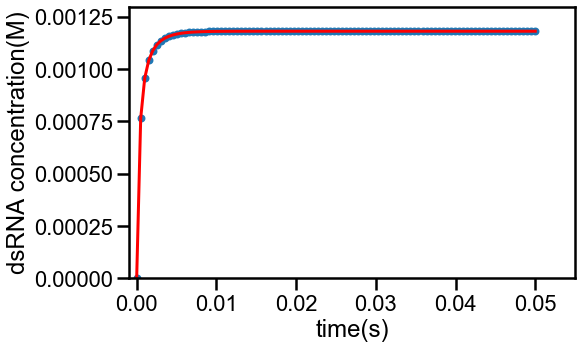

In [3]:
# unmodified RNA annealing model

# rate constants of unmodified RNA (dsGBC 65C no Mg2+, concentration 1.3mM) for the reaction
k_A = (2.2e6, 26.8)

# concentrations for each molecule, saved in a ordered dictionary
initial_c_A = [1.3/1000, 1.3/1000, 0.0]

# time 
t_A = np.linspace(0, 0.05, 100)

# starting duplex concentration
ct = 1.3/1000

# perform simulation and fitting (equation)
pB_ss, kon, koff, params, data, conc_results, err = get_fit_result(complex_model_A, A_annealing_model, 
                                                                   initial_c_A, t_A, k_A, ct)

# plot fitting results
plot_fitting(t_A, data, complex_model_A, params, pB_ss, kon, koff)

# double check pB using numerical integration results
final_pB = calc_all_pop(conc_results, ct)

# CS pathway simulation

kon is 269376.78+/-941.78
koff is 29.527037+/-0.138817
###numerical fitting
kon is 264906.60
koff is 28.855210
species 1 population is: 27.320%
species 2 population is: 2.147%
species 3 population is: 29.467%
species 4 population is: 70.533%


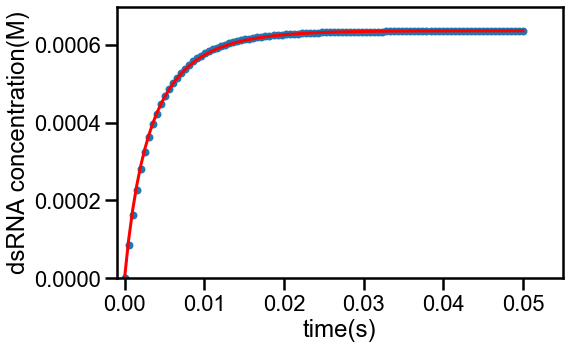

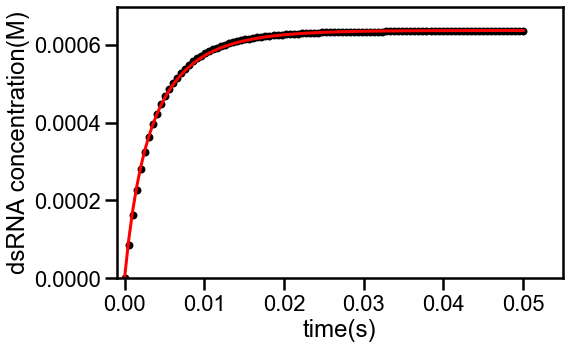

In [4]:
# rate constants, 65C dsGGACU
k_model1 = (1224.8, 15587.6, 4.3e6, 34.7)

# concentrations for each molecule, saved in a ordered dictionary
initial_c_model1 = [0.9/1000, 0.0, 0.9/1000, 0.0]

t_m6A_model1 = np.linspace(0, 0.05, 100)

# starting duplex concentration
ct_m6A = 0.9/1000

# perform simulation and fitting
pB_ss1, kon1, koff1, params1, data1, conc_results1,err = get_fit_result(complex_model_m6A, m6A_annealing_model_1, 
                                                initial_c_model1, t_m6A_model1, k_model1, ct_m6A,
                                                    p0 = (0.008, 1000),
                                                    bounds = ([7.8e-5, 0],[ 0.01, 1e6]))
# plot fitting results
plot_fitting(t_m6A_model1, data1, complex_model_m6A, params1, pB_ss1, kon1, koff1)

# numerical fitting
initial_c_m6A_2state = [0.9/1000, 0.9/1000, 0.0]

fit_result1 = minimize(min_fun, x0 = (8000, 0.5), 
                       args=(data1, t_m6A_model1, initial_c_m6A_2state), method='powell')['x']

# plot
plot_numeric_fitting(data1, t_m6A_model1, initial_c_m6A_2state, fit_result1)

# double check pB using numerical integration results
final_pB1 = calc_all_pop(conc_results1, ct_m6A)

# CS pathway population simulation with MC error sampling

pB of species 0 is (24.53+/-7.93)%
pB of species 1 is (2.05+/-0.66)%
pB of species 2 is (26.59+/-7.98)%
pB of species 3 is (73.41+/-7.98)%


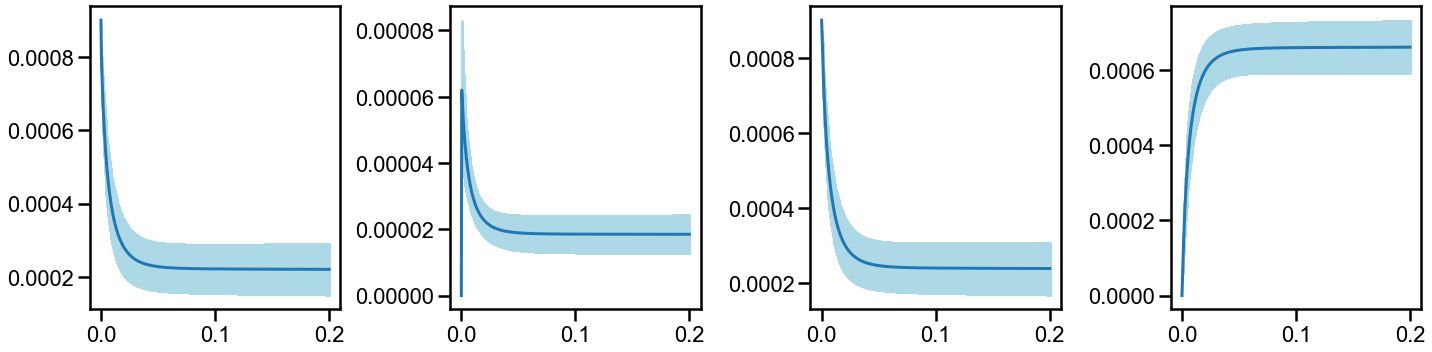

In [5]:
# dsGGACU 65C
# CS pathway step 1 rates
kcs_12, kcs_21 = ufloat(1224.782016333163, 325.29986473446286), ufloat(15587.552892102518,4783.620509452286)

# oevrall reaction rates
kt_12, kt_21 = ufloat(4.8e5, 0.7e5), ufloat(35.9, 0.4)

# dG of the methyl rotation step
dG1 = k_to_dg(kcs_12, kcs_21)

# dG of the overall reaction
dG_pB1 = -k_to_dg(kt_12, kt_21)

pb = ufloat(24.9, 0.1)/100
#partitioning pb
pb_syn = pb/(1+kcs_12/kcs_21)
dG_pB1 = k_to_dg(pb_syn**2*ct/(1-pb_syn), 1, 65+273.15)

# CS pathway step 2 forward rate, keep it the same as unmodified
ksc_34 = ufloat(2.2e6, 0.4e6)

# CS pathway step 2 reverse rate
ksc_43 = ksc_34/exp(-(dG_pB1+dG1)/(-R*(65+273.15)))

cs_k = [kcs_12, kcs_21, ksc_34, ksc_43]

# initial concentration
initial_c_cs = [0.9/1000, 0.0, 0.9/1000, 0.0]

# time
t_m6A_cs = np.linspace(0, 0.2, 500)

inte_results = MC_inte(m6A_annealing_model_1, initial_c_cs, t_m6A_cs, cs_k, it = 100, showfig=True)

# IF+CS simulation

kon is 482077.05+/-12022.70
koff is 1.287577+/-0.151632
###numerical fitting
kon is 482077.04
koff is 1.287577
species 1 population is: 4.104%
species 2 population is: 0.601%
species 3 population is: 1.300%
species 4 population is: 4.705%
species 5 population is: 93.995%


0.6257910295045992

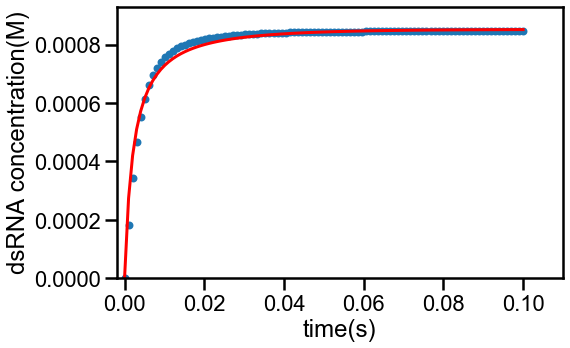

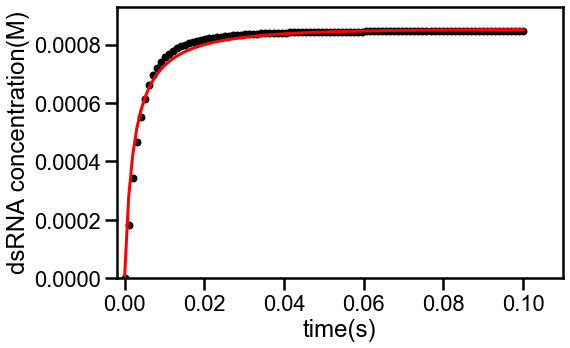

In [6]:
# m6A RNA annealing model 3, combined pathway 55C

# rate constants
k_model3 = get_rate_from_kex(515.9, 111.9, 132.818, 6400, 0.013, 0.041, 0.006, 0.9/1000)

c = 0.9/1000
# concentrations for each molecule, saved in a ordered dictionary
initial_c_model3 = [c, 0.0, 0.0, c, 0.0]

# time 
t_m6A_model3 = np.linspace(0, 0.1, 100)

# starting duplex concentration
ct_m6A = c

conc_results = odeint(m6A_annealing_model_3, initial_c_model3, t_m6A_model3, k_model3) 

# perform simulation and fitting
pB_ss3, kon3, koff3, params3, data3, conc_results3, err = get_fit_result(lambda x, eq, k: complex_model_m6A(x, eq, k, A = ct_m6A), m6A_annealing_model_3, 
                                                initial_c_model3, t_m6A_model3, k_model3, ct_m6A,
                                                    p0 = (.2e-4, 1e5),
                                                    bounds = ([2.2e-12, 5e4],[ 0.5e-1, 5.56e10]))

# plot fitting results
plot_fitting(t_m6A_model3, data3, complex_model_m6A, np.append(params3, ct_m6A), pB_ss3, kon3, koff3)

# numerical fitting
fit_result3 = minimize(min_fun, x0 = (kon3.n, koff3.n), args=(data3, t_m6A_model3, initial_c_m6A_2state), method='TNC')['x']

plot_numeric_fitting(data3, t_m6A_model3, initial_c_m6A_2state, fit_result3)

# double check pB using numerical integration results
final_pB3 = calc_all_pop(conc_results3, ct_m6A)

flux(k_model3, ct_m6A, final_pB3, detail=False)

# CS+IF pathway population simulation with MC error sampling

pB of species 0 is (25.56+/-4.48)%
pB of species 1 is (2.18+/-0.73)%
pB of species 2 is (1.10+/-0.27)%
pB of species 3 is (27.74+/-4.13)%
pB of species 4 is (71.16+/-4.31)%


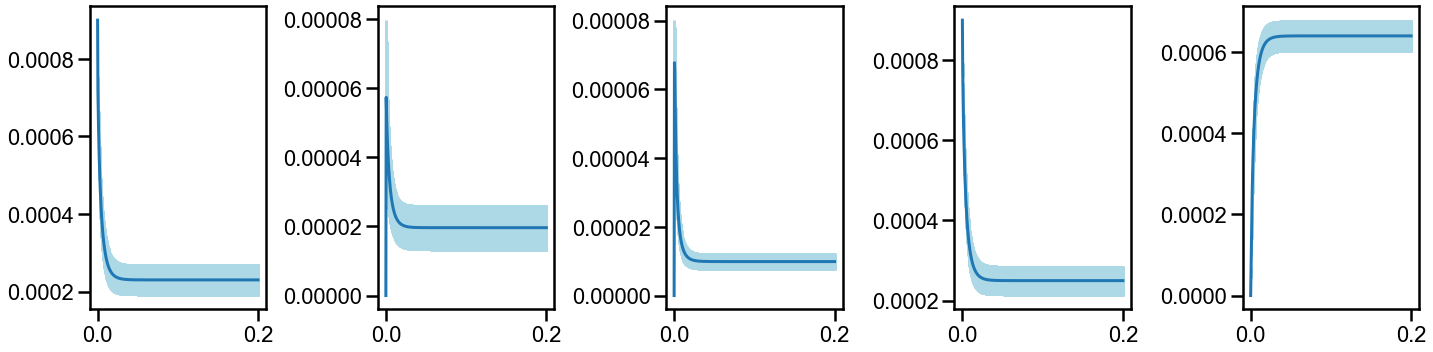

In [7]:
# IF dsGGACU 65C
# IF pathway step 2 rates
kif_34, kif_43 = ufloat(1095.6, 19.97), ufloat(17.4, 0.37)

# dG of the methyl rotation step
dG2 = k_to_dg(kif_34, kif_43)

# dG of the overall reaction
dG_pB1 = k_to_dg(pb_syn**2*ct/(1-pb_syn), 1, 65+273.15)

# CS pathway step 2 forward rate, keep it 1/20 of the unmodified
kif_12 = ufloat(13e6, 2e6)/20

# CS pathway step 2 reverse rate
kif_21 = kif_12/exp(-(dG_pB1+dG2)/(-R*(65+273.15)))

combined_k = [kcs_12, kcs_21, ksc_34, ksc_43, kif_43, kif_34, kif_12, kif_21]

# initial concentration
initial_c_combine = [0.9/1000, 0, 0.,0.9/1000, 0.0]

# time
t_m6A_combine = np.linspace(0, 0.2, 500)

inte_results = MC_inte(m6A_annealing_model_3, initial_c_combine, t_m6A_combine, combined_k, it = 100, showfig=True)

# Prediction using CS+IF

fitted kon is 6.2E+05 +/- 1.4E+05
fitted koff is 18.6 +/- 3.7
flux of IF is 19.3% +/- 4.3%
flux of if is (19.3+/-4.3)%
experimental slowdown is 8.83 +/- 0.48
predicted slowdown is 8.08 +/- 1.91


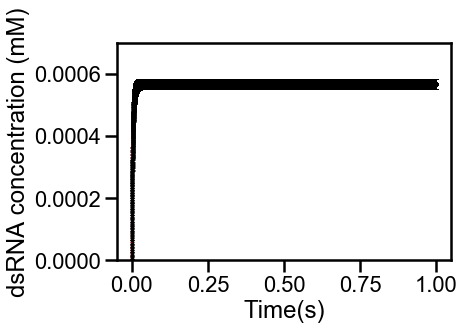

In [33]:
# dsHCV 60C Mg2+ data
#RD data A
kex_A2 = ufloat(285.8,12.5)
pB_A2 = ufloat(7.5,0.1)/100

# RD data m6A
kex_m6A2 = ufloat(88.2,2.2)
pB_m6A2 = ufloat(18.1,0.2)/100

t2 = 60+273.15

ct1_2 = 0.7/1000
ct2_2 = 0.7/1000

dsHCV_60C = cs_if_sim(kex_A2, pB_A2, kex_m6A2, pB_m6A2, t2, ct1_2, ct2_2, tmax = 1, detail=False, MC=True, cs_fold=0.5)

fitted kon is 3.5E+05 +/- 1.0E+05
fitted koff is 22.2 +/- 4.6
flux of IF is 20.0% +/- 3.9%
flux of if is (20.0+/-3.9)%
experimental slowdown is 4.58 +/- 0.12
predicted slowdown is 6.36 +/- 1.87


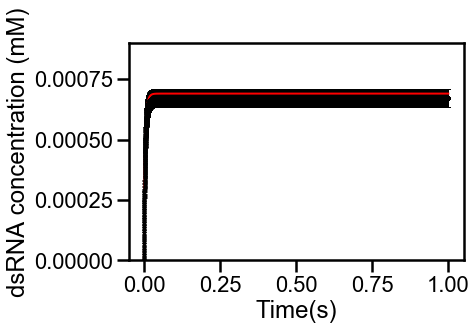

In [20]:
# dsGBC 65C data
#RD data A
kex_A4 = ufloat(291.4, 1.6)
pB_A4 = ufloat(9.2, 0.1)/100

# RD data m6A
kex_m6A4 = ufloat(144.0,3.0)
pB_m6A4 = ufloat(24.9,0.1)/100

t4 = 65+273.15

ct1_4 = 1.3/1000
ct2_4 = 0.9/1000

dsGGACU_65C = cs_if_sim(kex_A4, pB_A4, kex_m6A4, pB_m6A4, t4, ct1_4, ct2_4, tmax = 1, cs_fold=0.5, MC=True)

fitted kon is 8.3E+05 +/- 9.4E+04
fitted koff is 3.2 +/- 0.7
flux of IF is 20.4% +/- 3.7%
flux of if is (20.4+/-3.7)%
experimental slowdown is 19.18 +/- 2.03
predicted slowdown is 15.08 +/- 1.94


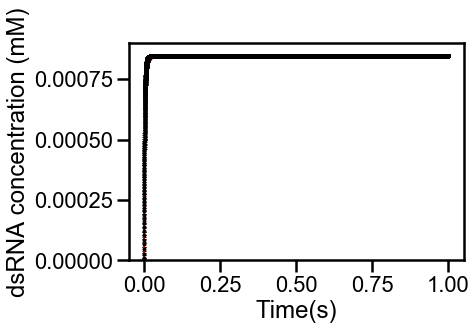

In [24]:
# daGBC 55C data
#RD data A
kex_A5 = ufloat(136.5,8.3)
pB_A5 = ufloat(0.83,0.01)/100

# RD data m6A
kex_m6A5 = ufloat(33.6,2.1)
pB_m6A5 = ufloat(5.4,0.3)/100

t5 = 55+273.15

ct1_5 = 1.3/1000
ct2_5 = 0.9/1000

dsGGACU_55C = cs_if_sim(kex_A5, pB_A5, kex_m6A5, pB_m6A5, t5, ct1_5, ct2_5, tmax = 1, cs_fold=0.5, MC=True, printout=True)

fitted kon is 1.7E+06 +/- 3.9E+05
fitted koff is 7.5 +/- 1.8
flux of IF is 23.7% +/- 7.2%
flux of if is (23.7+/-7.2)%
experimental slowdown is 8.48 +/- 0.58
predicted slowdown is 10.43 +/- 2.55


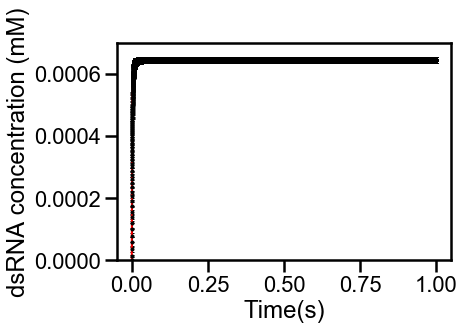

In [27]:
# dsGGACU 65C data Mg2+
#RD data A
kex_A6 = ufloat(221.2,5.7)
pB_A6 = ufloat(1.8,0.1)/100

# RD data m6A
kex_m6A6 = ufloat(103.8,2.5)
pB_m6A6 = ufloat(6.8,0.1)/100

t6 = 65+273.15

ct1_6 = 0.7/1000
ct2_6 = 0.7/1000

dsGGACU_65C_Mg = cs_if_sim(kex_A6, pB_A6, kex_m6A6, pB_m6A6, t6, ct1_6, ct2_6, tmax = 1, cs_fold=0.5, MC=True, it=100)

fitted kon is 2.1E+05 +/- 5.5E+04
fitted koff is 31.2 +/- 8.1
flux of IF is 17.3% +/- 4.0%
flux of if is (17.3+/-4.0)%
experimental slowdown is 6.76 +/- 0.10
predicted slowdown is 5.66 +/- 1.47


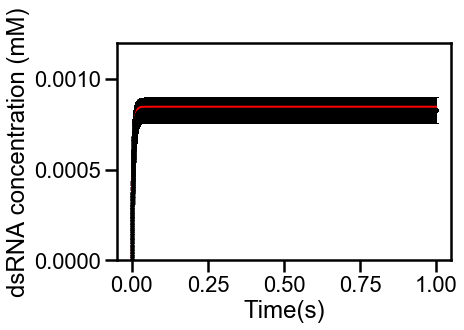

In [26]:
#A6DNA 50C RD data A
kex_A7 = ufloat(287,2)
pB_A7 = ufloat(20.9,0.1)/100

# RD data m6A
kex_m6A7 = ufloat(102.2,0.8)
pB_m6A7 = ufloat(32.3,0.2)/100

t7 = 65+273.15

ct1_7 = 0.9/1000
ct2_7 = 1.2/1000

A6DNA_50C = cs_if_sim(kex_A7, pB_A7, kex_m6A7, pB_m6A7, t7, ct1_7, ct2_7, tmax = 1, cs_fold=0.5, MC=True)